# Statystyczne metody przetwarzania danych 

## Laboratorium 3 - algorytm Najbliższej Średniej (NM)


### Opis
Celem laboratorium jest implementacja klasyfikatora najbliższej średniej NM (*Nearest Mean*).

### Zbiór danych

Zbiór danych znajduje się w `dataset/leaf.csv`. Jest to zbiór danych pobrany z adresu: <https://archive.ics.uci.edu/ml/datasets/leaf>.

### Przesyłanie zadań

Wszystkie pliki należy spakować archiwizatorem **zip** i przesłać za pośrednictwem platformy WIKAMP. Poniżej oczekiwana zawartość archiwum:

```
+-- 📂 [IMIE I NAZWISKO].zip
    +-- 📜 Lab03.ipynb
    +-- 📂 dataset
        +-- 📜 leaf.csv
        +-- 📜 ReadMe.pdf
```
**Edit: Skorzystać z tego samego zbioru danych, co w kNN.**

*UWAGA: Wysyłając zadanie potwierdasz, że wykonałeś je samodzielnie i jest to Twoja indywidualna praca i materiał przedstawiony w tej pracy jest dla Ciebie zrozumiały.*

### Zadanie

Należy wykonać następujące czynności w celu realizacji niniejszego zadania:
* Wczytaj dane.
* Zaimplementuj funkcję, która zwraca macierz kowariancji (*uwaga: biblioteka `numpy` posiada gotową implementację `cov` z którą możesz porównać wynik*).

\begin{equation*}
C = \frac{1}{n - 1} \sum_{i=1}^n (X_i - \bar X)(X_i - \bar X)^T
\end{equation*}

* **Zaimplementuj klasyfikator najbliższej średniej (NM) z zastosowaniem odległości Euklidesa**. - **Edit: moze byc gotowa**
* **Zaimplementuj klasyfikator najbliższej średniej (NM) z zastosowaniem odległości Machalanobisa**. - **Edit: napisac samemu**
* **Edit: liczba cech jak wpływa**

    \begin{equation*}
    D_j = \sqrt{ (x - \mu_j)^T S_j^{-1}(x - \mu_j) },
    \end{equation*}

    gdzie:
    * $D_j$ to odległość klasyfikowanej próbki do $j$-tej klasy (grupy, klastra), 
    * $\mu_j$ to wektor ze średnimi wartościami cech w obrębie $j$-tej klasy, 
    * $S_j^{-1}$ to odwrócona macierz kowariancji $j$-tej klasy, 
    * a $x$ to klasyfikowana próbka.

* Opisz wyniki klasyfikatorów i porównaj je z klasyfikatorem *k*NN (porównaj w kontekście różnych metryk - obowiązkowo tablica pomyłek).

> Podpowiedź 1: Do obliczenia macierzy odwrotnej możesz użyć gotową implementację, np. funkcję `linalg.inv` z biblioteki `numpy`.

> Podpowiedź 2: Do wszelkich podstawowych operacji na macierzach (mnożenie, transpozycja, dodawanie, odejmowanie, itp.) możesz zastosować gotową implementację, np. bibliotekę `numpy`.

> UWAGA 1: W niniejszym zadaniu jest dowolność implementacji (nie trzeba trzymać się struktury z poprzedniego zadania), jednak algorytm NM należy zaimplementować samodzielnie bez korzystania z istniających rozwiązań (jak np. z biblioteki `scikit-learn`).

> UWAGA 2: Wszystkie wykonane elementy zadania powinny posiadać stosowne komentarze i opisy.


**Pamiętaj, wyniki powinny być czytelnie opisane oraz zaprezentowane graficznie (jeżeli jest taka możliwość). Warstwa prezentacji danych to jeden z głównych elementów wpływających na ocenę.**

Przykład (na podstawie tablicy pomyłek):

Źle (nie wiadomo co jest poniżej zaprezentowane, kolumny ani wiersze nie są podpisane, nie wiadomo które z nich prezentują predykcje, a które właściwe etykiety):
```
array([[2, 0, 0],
       [0, 0, 1],
       [1, 0, 2]])
```


<span style="text-decoration:underline">Referencje</span>

1. Mahalanobis, P C, _On test and measures of group divergence : theoretical formulae_, Journal and Proceedings of Asiatic Society of Bengal (New Series) Vol. 26, pp. 541-588. 1930. (URL: http://library.isical.ac.in:8080/xmlui/bitstream/handle/10263/1639/029.pdf)
2. McLachlan, Goeffrey J. _Mahalanobis distance_, Resonance, pp. 20-26. 1999. (URL: https://www.ias.ac.in/article/fulltext/reso/004/06/0020-0026)

### Wczytywanie danych

In [1]:
# Piotr Klimczak, 1SIiUM2, 239533 / 215275

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

with open('./dataset/dataset.npz', 'rb') as f:
    data = np.load(f)
    train, test = data['train'], data['test']

### Przygotowanie danych

In [2]:
columns_name = ['Class (Species)','Specimen Number','Eccentricity','Aspect Ratio','Elongation','Solidity',
                'Stochastic Convexity','Isoperimetric Factor','Maximal Indentation Depth','Lobedness',
                'Average Intensity','Average Contrast','Smoothness','Third moment','Uniformity','Entropy']

df_train = pd.DataFrame(train, columns = columns_name)
df_test = pd.DataFrame(test, columns = columns_name)

### Obróbka danych do macierzy kowariancji

In [3]:
def Macierz_x(klasy,cechy,czy_normalizowac,dane):
    # tworzenie macierzy x, gdzie:
    # - kolumny to x1, x2, ... - punkty klasy, stworzone z:
    # - wiersz 1 to oś 'x', wiersz 2 to 'y' ('x', 'y' - cechy)
    
    # len(klasy), np. array o 2 miejscach bo są 2 klasy
    # dtype=object, by moc przechowywac array w arrayu
    cechy_danej_klasy = np.empty([len(klasy)], dtype=object)
    
    #tyle, ile jest klas
    for y in range(len(klasy)):
        # pobierz wszystkie cechy z danej klasy
        # .T - transpozycja (tutaj z kolumn na wiersze)
        cechy_danej_klasy[y] = dane[cechy].loc[dane['Class (Species)'] == klasy[y]].T.to_numpy()
        
    if czy_normalizowac == 'tak':
        cechy_danej_klasy = Normalizuj(cechy_danej_klasy)
                                                               
    return (cechy_danej_klasy, czy_normalizowac)

def Normalizuj(dane): #mozliwa kombinacja: 2klasy2cechy, 5klas2cechy, 2klasy5cech,  5klas5cech
    #Jezeli znajdzie sie chwila to wymyslic lepsza optymalizacje tej funkcji, bo jest tragiczna

    polaczone = Polacz(dane)

    for v in range(len(cechy)): #w zakresie wszystkich cech
        
        for p in range(len(polaczone[v])): #w zakresie wszystkich probek
            polaczone[v][p] = ((polaczone[v][p] - np.min(polaczone[v][:])) / (np.max(polaczone[v][:]) - np.min(polaczone[v][:])))
        
        #Rozdzielanie z wszystkich polaczonych, na odpowiednie cechy (da sie to zrobic, bo znamy dlugosci wsadzanych danych)
        if len(klasy) == 2:
            a = len(dane[0][v]) 
            dane[0][v] = polaczone[v][0:len(dane[0][v])] #1 cecha
            dane[1][v] = polaczone[v][len(dane[0][v]):] #2 cecha
            #print(a)
            #print(len(dane[0][v]))
            #print(len(dane[1][v]))
        if len(klasy) == 5:
            a = len(dane[0][v]) 
            b = len(dane[1][v])  
            c = len(dane[2][v]) 
            d = len(dane[3][v])
            #print(a)
            #print(b)
            #print(c)
            #print(d)
            dane[0][v] = polaczone[v][0:a] #1 klasa 
            dane[1][v] = polaczone[v][a:(a+b)] #2 klasa 77 
            dane[2][v] = polaczone[v][(a+b):(a+b+c)] #3 klasa 
            dane[3][v] = polaczone[v][(a+b+c):(a+b+c+d)] #4 klasa 
            dane[4][v] = polaczone[v][(a+b+c+d):] #5 klasa

    return(dane)

def Polacz(dane):
    #Jak zrobic, by do concatenate 'mądrze' wchodziły dane? Jakas pętla w srodku / lambda?
    polaczone = np.empty([len(cechy)], dtype=object) #polaczone cechy wszystkich klas
   
    if (len(cechy) == 2 and len(klasy) == 2):
        polaczone[0] = np.concatenate((dane[0][0],dane[1][0])) #kl35c1
        polaczone[1] = np.concatenate((dane[0][1],dane[1][1])) #kl35c2
    if (len(cechy) == 2 and len(klasy) == 5):
        polaczone[0] = np.concatenate((dane[0][0],dane[1][0],dane[2][0],dane[3][0],dane[4][0])) #kl[29,5,8,4,31,3]c1
        polaczone[1] = np.concatenate((dane[0][1],dane[1][1],dane[2][1],dane[3][1],dane[4][1])) #kl[29,5,8,4,31,3]c2      
    if (len(cechy) == 5 and len(klasy) == 2):
        polaczone[0] = np.concatenate((dane[0][0],dane[1][0])) #kl35c1
        polaczone[1] = np.concatenate((dane[0][1],dane[1][1])) #kl35c2
        polaczone[2] = np.concatenate((dane[0][2],dane[1][2])) #kl35c3
        polaczone[3] = np.concatenate((dane[0][3],dane[1][3])) #kl35c4
        polaczone[4] = np.concatenate((dane[0][4],dane[1][4])) #kl35c5
    if (len(cechy) == 5 and len(klasy) == 5):
        polaczone[0] = np.concatenate((dane[0][0],dane[1][0],dane[2][0],dane[3][0],dane[4][0])) #kl[29,5,8,4,31,3]c1
        polaczone[1] = np.concatenate((dane[0][1],dane[1][1],dane[2][1],dane[3][1],dane[4][1])) #kl[29,5,8,4,31,3]c2
        polaczone[2] = np.concatenate((dane[0][2],dane[1][2],dane[2][2],dane[3][2],dane[4][2])) #kl[29,5,8,4,31,3]c3
        polaczone[3] = np.concatenate((dane[0][3],dane[1][3],dane[2][3],dane[3][3],dane[4][3])) #kl[29,5,8,4,31,3]c4
        polaczone[4] = np.concatenate((dane[0][4],dane[1][4],dane[2][4],dane[3][4],dane[4][4])) #kl[29,5,8,4,31,3]c5

    return(polaczone)

def Macierz_mi(dane):
    # uśrednianie
    mi = np.empty(len(dane), dtype=object)
    
    # tyle, ile bylo cech
    for y in range((len(dane))):
        # policz średnią po axis=1 czyli poziomo
        mi[y] = np.sum(dane[y],axis=1) / dane[y].shape[1]
        
    return(mi)

def Macierz_M(dane_mi,dane_x):
    #stworz array o dlugosci ilosci klas (len(mi) moze byc, bo mi powstalo z len(x), x powstalo z len(klasy))
    M = np.empty(len(dane_mi), dtype=object)
    
    for y in range(len(klasy)): #powtorz tyle, ile jest klas
        for z in range(dane_x[y].shape[1]): #powtorz tyle, ile jest kolumn/punktów w danej klasie
            M[y] = np.vstack( [dane_mi[y]] * dane_x[y].shape[1] ).T #skopiuj mi do M tyle razy, ile jest kolumn/punktów w klasie
            
    return(M)

def PolaczWKolumny(dane):
    return_dane = np.empty(len(klasy), dtype=object)
    
    if len(cechy) == 2:
        for t in range(len(klasy)):
            return_dane[t] = np.stack((dane[t][0],dane[t][1]),axis=1) 
        
    if len(cechy) == 5:
        for t in range(len(klasy)):
            return_dane[t] = np.stack((dane[t][0],dane[t][1],dane[t][2],dane[t][3],dane[t][4]),axis=1)
 
    return(return_dane)

def OdlegloscEuklidesa():
    return_odleglosc = np.empty(len(klasy)*len(mi), dtype=object)
    #klasa * ileś M liczyć, wiec dlatego
    #np. dla klasy 3, trzeba policzyc euklidesa do mi3 oraz mi5
    
    zrobiona_klasa=0 #zmienna pomocnicza, by zgadzały się indeksy
    #przykład dla 5 klas: każda klasa musi zostać policzona 5 razy (do każdego mi zmierzyć odległość)
        #[k+g+zrobiona_klasa]: 000, 010, 020, 030, 040 | 104, 114, 124, 134, 144 | 208, 219, ... za kazdym razem wyjdzie indeks odpowiedni (jako suma!)

    for k in range(len(klasy)): #tyle, ile jest klas
        for g in range(len(mi)): #np. dla klasy 3, trzeba policzyc euklidesa do mi3 oraz mi5
            return_odleglosc[k+g+zrobiona_klasa] = x_testowe[k] - mi[g]
            for j in range(len(return_odleglosc[k+g+zrobiona_klasa])): #dla wszystkich próbek
                return_odleglosc[k+g+zrobiona_klasa][j] = np.sqrt(return_odleglosc[k+g+zrobiona_klasa][j] **2)
                return_odleglosc[k+g+zrobiona_klasa][j] = np.sum(return_odleglosc[k+g+zrobiona_klasa][j])
                return_odleglosc[k+g+zrobiona_klasa][j] = np.sqrt(return_odleglosc[k+g+zrobiona_klasa][j])
        zrobiona_klasa += len(klasy) - 1  
    return(return_odleglosc)

def OdlegloscMachalanobisa():
    return_odleglosc = np.empty(len(klasy)*len(mi), dtype=object) #25
    mi_rozmiar = mi.reshape(mi.shape+(1,))
    
    zrobiona_klasa=0 

    for k in range(len(klasy)): #tyle, ile jest klas
        for g in range(len(mi)): #np. dla klasy 3, trzeba policzyc do mi3 oraz mi5
            return_odleglosc[k+g+zrobiona_klasa] = np.empty(x_testowe[k].shape[0], dtype=object) #stworz podtablice
            for j in range(len(return_odleglosc[k+g+zrobiona_klasa])): #dla wszystkich próbek
                return_odleglosc[k+g+zrobiona_klasa][j] = (x_testowe[k] - mi[g])[j] @ C_odwrocone[k] @ (x_testowe[k] - mi[g])[j].reshape((x_testowe[k] - mi[g])[j].shape+(1,))
        zrobiona_klasa += len(klasy) - 1  
    return(return_odleglosc)  

def StworzMin(dane):
    return_min_euk = np.empty(len(klasy), dtype=object)
    przypisanie = np.empty(len(klasy), dtype=object)

    okres = 0
    for k in range(len(klasy)):
        return_min_euk[k] = np.empty(dane[k+okres].shape[0], dtype=object) #stworz podtablice
        przypisanie[k] = np.empty(dane[k+okres].shape[0], dtype=object) #stworz podtablice
        for i in range(dane[k+okres].shape[0]):
            if len(klasy) == 5:
                return_min_euk[k][i] = np.stack([dane[0+okres][i][0],dane[1+okres][i][0],dane[2+okres][i][0],dane[3+okres][i][0],dane[4+okres][i][0]])
            if len(klasy) == 2:
                return_min_euk[k][i] = np.stack([dane[0+okres][i][0],dane[1+okres][i][0]])
                
            przypisanie[k][i] = np.argmin(return_min_euk[k][i],axis=0)

        okres += len(klasy)
        
    return(przypisanie)

def Matrix(test,result):
    unique = np.unique([test, result])
    
    conmat = pd.DataFrame(
        confusion_matrix(test, result),
        index = ['TRUE:{:}'.format(x) for x in unique],
        columns = ['PRED:{:}'.format(x) for x in unique]
    )
    
    print(conmat)

def PokazMatrix_i_Dokladnosc():
    kl0 = np.full(len(ans[0]),0)
    kl1 = np.full(len(ans[1]),1)
    kltotal = list(kl0) + list(kl1) 
    anstotal = list(ans[0]) + list(ans[1])
    if len(klasy) == 5:
        kl2 = np.full(len(ans[2]),2)
        kl3 = np.full(len(ans[3]),3)
        kl4 = np.full(len(ans[4]),4)
        kltotal = list(kl0) + list(kl1) + list(kl2) + list(kl3) + list(kl4)
        anstotal = list(ans[0]) + list(ans[1]) + list(ans[2]) + list(ans[3]) + list(ans[4])

    matrixx = Matrix(kltotal,anstotal)
    
    zgodne = 0 #init & czysc zmienna

    for i in range(len(kltotal)):
        if ((kltotal)[i]  == (anstotal)[i]): #czy pokrywa się klasyfikacja
            zgodne += 1 #jeżeli tak, +1
        
    acc = zgodne / len(kltotal)
    print("\n")
    print("Dokładność: ",acc*100,'%')

### 2cechy2klasy

In [4]:
wszystkie_treningowe = df_train.loc[(df_train['Class (Species)'].isin([29,5,8,4,31,3]))]
wszystkie_testowe = df_test.loc[(df_test['Class (Species)'].isin([29,5,8,4,31,3]))]

# wybrane klasy z wszystkich:
#klasy = [29,5,8,4,31]
klasy = [3,5]

# wybieranie cech (narazie dwóch), z których zrobimy problem 2D, Entropy - 'x', Elongation - 'y'
cechy = ["Eccentricity","Elongation"]
#cechy = ['Elongation','Entropy','Aspect Ratio','Lobedness','Solidity']

x, czy_normalizowane = Macierz_x(klasy,cechy,'tak',wszystkie_treningowe)
#To, czy są znormalizowane dane, zależy od 3 parametru - 'tak' lub 'nie' (tak naprawde dowolny ciag, inny od 'tak');
#x[0] <- wszystkie cechy pierwszej podanej klasy; [1] - drugiej podanej klasy
#x[0][0] <- 'x' podanej pierwszej klasy; [0][1] - 'y'

#dostęp do mi analogiczny jak w przypadku x
mi = Macierz_mi(x)

#dostęp do M analogiczny jak w przypadku x
M = Macierz_M(mi,x)

### 2cechy2klasy Euklides



In [5]:
x_testowe, czy_normalizowane_testowe = Macierz_x(klasy,cechy,'tak',wszystkie_testowe)

mi_testowe = Macierz_mi(x_testowe)

M_testowe = Macierz_M(mi_testowe,x_testowe)

x_testowe = PolaczWKolumny(x_testowe)

euklides = OdlegloscEuklidesa()

ans = StworzMin(euklides)

PokazMatrix_i_Dokladnosc()



        PRED:0  PRED:1
TRUE:0      55       0
TRUE:1       0      55


Dokładność:  100.0 %


### Macierz kowariancji

In [6]:
#len(x[0][0]) - [pierwsza klasa][x lub y, musi byc tyle samo pkt], a ja chce ile jest tych x lub y, ze punktow lacznie

v = x - M
print(x)

C = np.empty(len(klasy), dtype=object)

for y in range(len(klasy)):
    C[y] = (1/(len(x[y][0])-1)) * v[y] @ v[y].T
    
#Jeżeli dzielenie miałoby być przez N tylko (aktualnie jest przez N-1), należy w np.cov dodać parametr bias=False
        
print("Macierz C klasy {}:\n".format(klasy), C, "\n")

for z in range(len(klasy)):
    print("Macierz C klasy [{}]:\n".format(klasy[z]), np.cov(x[z]), "\n")

[array([[0.25464672, 0.32459958, 0.58946953, 0.4648883 , 0.5449518 ,
        0.28372736, 0.43209376, 0.70426807, 0.51157321, 0.53995088,
        0.53438447, 0.20786983, 0.58854962, 0.5755769 , 0.57245225,
        0.53796718, 0.3223797 , 0.71876085, 0.60306224, 0.50866223,
        0.31509851, 0.3494421 , 0.53958974, 0.40055308, 0.6906516 ,
        0.39685486, 0.35090708, 0.53745716, 0.42444647, 0.52951428,
        0.39771826, 0.3569936 , 0.60148079, 0.44452505, 0.59422293,
        0.50419253, 0.49171842, 0.65946511, 0.53765185, 0.66800892,
        0.50188107, 0.25843742, 0.6969938 , 0.46084242, 0.52573533,
        0.42660588, 0.29005077, 0.59932411, 0.5181009 , 0.4532689 ,
        0.35786681, 0.30142002, 0.73869906, 0.61872112, 0.57274104],
       [0.21617624, 0.13553726, 0.34022473, 0.31246962, 0.37225447,
        0.25152436, 0.17451312, 0.38499359, 0.23408031, 0.41048829,
        0.24490197, 0.18997288, 0.45338845, 0.36854845, 0.26687052,
        0.23087924, 0.1403431 , 0.31950001, 0.

### 2cechy2klasy Machalanobis

In [7]:
C_odwrocone = np.empty(len(klasy), dtype=object)

for z in range(len(C)):
    C_odwrocone[z] = np.linalg.inv(C[z])

x_testowe, czy_normalizowane_testowe = Macierz_x(klasy,cechy,'tak',wszystkie_testowe)
x_testowe_plot = x_testowe

M_testowe = Macierz_M(mi_testowe,x_testowe)

x_testowe = PolaczWKolumny(x_testowe)

machalanobis = OdlegloscMachalanobisa()

ans = StworzMin(machalanobis)

PokazMatrix_i_Dokladnosc()

        PRED:0  PRED:1
TRUE:0      54       1
TRUE:1       0      55


Dokładność:  99.0909090909091 %


### Plot 2cechy2klasy

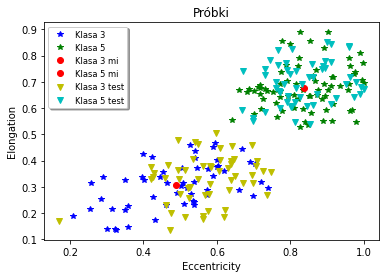

In [8]:
def Rysuj(ktora_w_kolejnosci_klasa, ile_cech,dane):
    #ktora_w_kolejnosci_klasa, mam na mysli zmienna klasa i np. [3, 5], to 3 jest 0, a 5 jest 1
    zwroc = np.empty([ile_cech], dtype=object)
    for y in range(ile_cech):
        zwroc[y] = dane[ktora_w_kolejnosci_klasa][y]
    return(zwroc)

plt.figure()
plt.title("Próbki")
plt.xlabel(f"Eccentricity")
plt.ylabel(f"Elongation")

kl3_cecha1, kl3_cecha2 = Rysuj(0,2,x)
kl5_cecha1, kl5_cecha2 = Rysuj(1,2,x)
kl3_cecha1_test, kl3_cecha2_test = Rysuj(0,2,x_testowe_plot)
kl5_cecha1_test, kl5_cecha2_test = Rysuj(1,2,x_testowe_plot)

plt.plot(kl3_cecha1,kl3_cecha2,"*b",label='Klasa 3') 
plt.plot(kl5_cecha1,kl5_cecha2,"*g",label='Klasa 5') 
plt.plot(mi[0][0],mi[0][1],"or",label='Klasa 3 mi')
plt.plot(mi[1][0],mi[1][1],"or",label='Klasa 5 mi')
plt.plot(kl3_cecha1_test,kl3_cecha2_test,"yv",label='Klasa 3 test') 
plt.plot(kl5_cecha1_test,kl5_cecha2_test,"cv",label='Klasa 5 test') 

legend = plt.legend(loc='best', shadow=True, fontsize='small')
plt.show()

### 5cechy2klasy

In [9]:
wszystkie_treningowe = df_train.loc[(df_train['Class (Species)'].isin([29,5,8,4,31,3]))]
wszystkie_testowe = df_test.loc[(df_test['Class (Species)'].isin([29,5,8,4,31,3]))]

# wybrane klasy z wszystkich:
klasy = [29,5,8,4,31]
#klasy = [3,5]

# wybieranie cech (narazie dwóch), z których zrobimy problem 2D, Entropy - 'x', Elongation - 'y'
cechy = ["Entropy","Elongation"]
#cechy = ['Elongation','Entropy','Aspect Ratio','Lobedness','Solidity']

x, czy_normalizowane = Macierz_x(klasy,cechy,'tak',wszystkie_treningowe)
#To, czy są znormalizowane dane, zależy od 3 parametru - 'tak' lub 'nie' (tak naprawde dowolny ciag, inny od 'tak');
#x[0] <- wszystkie cechy pierwszej podanej klasy; [1] - drugiej podanej klasy
#x[0][0] <- 'x' podanej pierwszej klasy; [0][1] - 'y'

#dostęp do mi analogiczny jak w przypadku x
mi = Macierz_mi(x)

#dostęp do M analogiczny jak w przypadku x
M = Macierz_M(mi,x)

### 5cechy2klasy Euklides

In [10]:
x_testowe, czy_normalizowane_testowe = Macierz_x(klasy,cechy,'tak',wszystkie_testowe)

mi_testowe = Macierz_mi(x_testowe)

M_testowe = Macierz_M(mi_testowe,x_testowe)

x_testowe = PolaczWKolumny(x_testowe)

euklides = OdlegloscEuklidesa()

ans = StworzMin(euklides)

PokazMatrix_i_Dokladnosc()


        PRED:0  PRED:1  PRED:2  PRED:3  PRED:4
TRUE:0      22       0       0       0       0
TRUE:1       0      55       0       0       0
TRUE:2       0       7      79       0       2
TRUE:3       0       1       0      21       0
TRUE:4       0       0      17       0      27


Dokładność:  88.31168831168831 %


### Macierz kowariancji

In [11]:
#len(x[0][0]) - [pierwsza klasa][x lub y, musi byc tyle samo pkt], a ja chce ile jest tych x lub y, ze punktow lacznie

v = x - M

C = np.empty(len(klasy), dtype=object)

for y in range(len(klasy)):
    C[y] = (1/(len(x[y][0])-1)) * v[y] @ v[y].T
    
#Jeżeli dzielenie miałoby być przez N tylko (aktualnie jest przez N-1), należy w np.cov dodać parametr bias=False
        
print("Macierz C klasy {}:\n".format(klasy), C, "\n")

for z in range(len(klasy)):
    print("Macierz C klasy [{}]:\n".format(klasy[z]), np.cov(x[z]), "\n")

Macierz C klasy [29, 5, 8, 4, 31]:
 [array([[ 0.00230709, -0.00035684],
       [-0.00035684,  0.00339641]])
 array([[ 5.42690756e-03, -5.11894620e-05],
       [-5.11894620e-05,  4.51659598e-03]])
 array([[ 0.00516104, -0.00042939],
       [-0.00042939,  0.00195216]])
 array([[ 0.02860386, -0.00565884],
       [-0.00565884,  0.00757019]])
 array([[ 0.01601219, -0.00022992],
       [-0.00022992,  0.0024257 ]])] 

Macierz C klasy [29]:
 [[ 0.00230709 -0.00035684]
 [-0.00035684  0.00339641]] 

Macierz C klasy [5]:
 [[ 5.42690756e-03 -5.11894620e-05]
 [-5.11894620e-05  4.51659598e-03]] 

Macierz C klasy [8]:
 [[ 0.00516104 -0.00042939]
 [-0.00042939  0.00195216]] 

Macierz C klasy [4]:
 [[ 0.02860386 -0.00565884]
 [-0.00565884  0.00757019]] 

Macierz C klasy [31]:
 [[ 0.01601219 -0.00022992]
 [-0.00022992  0.0024257 ]] 



### 5cechy2klasy Machalanobis

In [12]:
C_odwrocone = np.empty(len(klasy), dtype=object)

for z in range(len(C)):
    C_odwrocone[z] = np.linalg.inv(C[z])

x_testowe, czy_normalizowane_testowe = Macierz_x(klasy,cechy,'tak',wszystkie_testowe)
x_testowe_plot = x_testowe

M_testowe = Macierz_M(mi_testowe,x_testowe)

x_testowe = PolaczWKolumny(x_testowe)

machalanobis = OdlegloscMachalanobisa()

ans = StworzMin(machalanobis)

PokazMatrix_i_Dokladnosc()

        PRED:0  PRED:1  PRED:2  PRED:3  PRED:4
TRUE:0      22       0       0       0       0
TRUE:1       0      55       0       0       0
TRUE:2       0       1      84       0       3
TRUE:3       0       4       0      18       0
TRUE:4       0       0      11       0      33


Dokładność:  91.77489177489177 %


### Plot 5klas2cechy

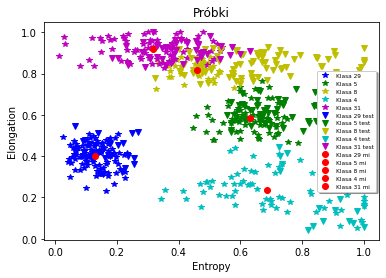

In [13]:
plt.figure()
plt.title("Próbki")
plt.xlabel(f"Entropy")
plt.ylabel(f"Elongation")

#klasy = [29,5,8,4,31]

kl29_cecha1, kl29_cecha2 = Rysuj(0,2,x)
kl5_cecha1, kl5_cecha2 = Rysuj(1,2,x)
kl8_cecha1, kl8_cecha2 = Rysuj(2,2,x)
kl4_cecha1, kl4_cecha2 = Rysuj(3,2,x)
kl31_cecha1, kl31_cecha2 = Rysuj(4,2,x)

kl29_cecha1_test, kl29_cecha2_test = Rysuj(0,2,x_testowe_plot)
kl5_cecha1_test, kl5_cecha2_test = Rysuj(1,2,x_testowe_plot)
kl8_cecha1_test, kl8_cecha2_test = Rysuj(2,2,x_testowe_plot)
kl4_cecha1_test, kl4_cecha2_test = Rysuj(3,2,x_testowe_plot)
kl31_cecha1_test, kl31_cecha2_test = Rysuj(4,2,x_testowe_plot)

plt.plot(kl29_cecha1,kl29_cecha2,"*b",label='Klasa 29') 
plt.plot(kl5_cecha1,kl5_cecha2,"*g",label='Klasa 5') 
plt.plot(kl8_cecha1,kl8_cecha2,"*y",label='Klasa 8') 
plt.plot(kl4_cecha1,kl4_cecha2,"*c",label='Klasa 4') 
plt.plot(kl31_cecha1,kl31_cecha2,"*m",label='Klasa 31') 

                                         
plt.plot(kl29_cecha1_test,kl29_cecha2_test,"bv",label='Klasa 29 test')
plt.plot(kl5_cecha1_test,kl5_cecha2_test,"gv",label='Klasa 5 test') 
plt.plot(kl8_cecha1_test,kl8_cecha2_test,"yv",label='Klasa 8 test') 
plt.plot(kl4_cecha1_test,kl4_cecha2_test,"cv",label='Klasa 4 test') 
plt.plot(kl31_cecha1_test,kl31_cecha2_test,"mv",label='Klasa 31 test') 

plt.plot(mi[0][0],mi[0][1],"or",label='Klasa 29 mi')
plt.plot(mi[1][0],mi[1][1],"or",label='Klasa 5 mi')
plt.plot(mi[2][0],mi[2][1],"or",label='Klasa 8 mi')
plt.plot(mi[3][0],mi[3][1],"or",label='Klasa 4 mi')
plt.plot(mi[4][0],mi[4][1],"or",label='Klasa 31 mi')
                                         
legend = plt.legend(loc='best', shadow=True, fontsize='xx-small')
plt.show()

### 5cechy5klas

In [14]:
wszystkie_treningowe = df_train.loc[(df_train['Class (Species)'].isin([29,5,8,4,31,3]))]
wszystkie_testowe = df_test.loc[(df_test['Class (Species)'].isin([29,5,8,4,31,3]))]

# wybrane klasy z wszystkich:
klasy = [29,5,8,4,31]
#klasy = [3,5]

# wybieranie cech (narazie dwóch), z których zrobimy problem 2D, Entropy - 'x', Elongation - 'y'
#cechy = ["Entropy","Elongation"]
cechy = ['Elongation','Entropy','Aspect Ratio','Lobedness','Solidity']

x, czy_normalizowane = Macierz_x(klasy,cechy,'tak',wszystkie_treningowe)
#To, czy są znormalizowane dane, zależy od 3 parametru - 'tak' lub 'nie' (tak naprawde dowolny ciag, inny od 'tak');
#x[0] <- wszystkie cechy pierwszej podanej klasy; [1] - drugiej podanej klasy
#x[0][0] <- 'x' podanej pierwszej klasy; [0][1] - 'y'

#dostęp do mi analogiczny jak w przypadku x
mi = Macierz_mi(x)

#dostęp do M analogiczny jak w przypadku x
M = Macierz_M(mi,x)

### 5cechy5klas Euklides

In [15]:
x_testowe, czy_normalizowane_testowe = Macierz_x(klasy,cechy,'tak',wszystkie_testowe)

mi_testowe = Macierz_mi(x_testowe)

M_testowe = Macierz_M(mi_testowe,x_testowe)

x_testowe = PolaczWKolumny(x_testowe)

euklides = OdlegloscEuklidesa()

ans = StworzMin(euklides)

PokazMatrix_i_Dokladnosc()

        PRED:0  PRED:1  PRED:2  PRED:3  PRED:4
TRUE:0      22       0       0       0       0
TRUE:1       0      55       0       0       0
TRUE:2       0       0      88       0       0
TRUE:3       0       0       0      22       0
TRUE:4       0       0       9       0      35


Dokładność:  96.1038961038961 %


### Macierz kowariancji

In [16]:
#len(x[0][0]) - [pierwsza klasa][x lub y, musi byc tyle samo pkt], a ja chce ile jest tych x lub y, ze punktow lacznie

v = x - M

C = np.empty(len(klasy), dtype=object)

for y in range(len(klasy)):
    C[y] = (1/(len(x[y][0])-1)) * v[y] @ v[y].T
    
#Jeżeli dzielenie miałoby być przez N tylko (aktualnie jest przez N-1), należy w np.cov dodać parametr bias=False
        
print("Macierz C klasy {}:\n".format(klasy), C, "\n")

for z in range(len(klasy)):
    print("Macierz C klasy [{}]:\n".format(klasy[z]), np.cov(x[z]), "\n")

Macierz C klasy [29, 5, 8, 4, 31]:
 [array([[ 3.39640642e-03, -3.56843481e-04,  3.16739293e-04,
        -5.04438783e-05,  2.69835034e-04],
       [-3.56843481e-04,  2.30708525e-03, -2.54709890e-05,
         1.52529212e-04, -4.60514404e-04],
       [ 3.16739293e-04, -2.54709890e-05,  3.78256171e-04,
         6.50980079e-05, -2.43911280e-04],
       [-5.04438783e-05,  1.52529212e-04,  6.50980079e-05,
         1.87105856e-04, -4.81710741e-04],
       [ 2.69835034e-04, -4.60514404e-04, -2.43911280e-04,
        -4.81710741e-04,  1.68950705e-02]])
 array([[ 4.51659598e-03, -5.11894620e-05,  1.01355753e-03,
         1.31867824e-03,  1.22755501e-04],
       [-5.11894620e-05,  5.42690756e-03, -2.07414898e-04,
         7.99398071e-04,  2.42299477e-04],
       [ 1.01355753e-03, -2.07414898e-04,  8.69057338e-04,
         3.75587050e-04, -3.02064300e-04],
       [ 1.31867824e-03,  7.99398071e-04,  3.75587050e-04,
         1.51900619e-03, -6.12839420e-05],
       [ 1.22755501e-04,  2.42299477e-04, -

### 5cechy5klas Machalanobis

In [17]:
C_odwrocone = np.empty(len(klasy), dtype=object)

for z in range(len(C)):
    C_odwrocone[z] = np.linalg.inv(C[z])

x_testowe, czy_normalizowane_testowe = Macierz_x(klasy,cechy,'tak',wszystkie_testowe)
x_testowe_plot = x_testowe

M_testowe = Macierz_M(mi_testowe,x_testowe)

x_testowe = PolaczWKolumny(x_testowe)

machalanobis = OdlegloscMachalanobisa()

ans = StworzMin(machalanobis)

PokazMatrix_i_Dokladnosc()

        PRED:0  PRED:1  PRED:2  PRED:3  PRED:4
TRUE:0      22       0       0       0       0
TRUE:1       0      52       0       3       0
TRUE:2       0      11      77       0       0
TRUE:3       0       9       0      13       0
TRUE:4       0       0       0       0      44


Dokładność:  90.04329004329004 %


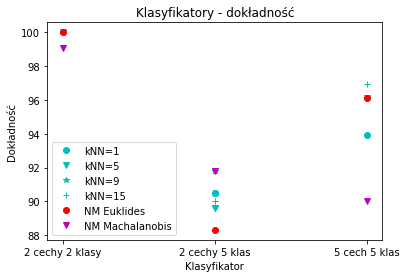

In [18]:
plt.figure()
plt.title("Klasyfikatory - dokładność")
plt.xlabel('Klasyfikator')
plt.ylabel('Dokładność')
plt.plot('2 cechy 2 klasy',100,'co', label="kNN=1")
plt.plot('2 cechy 2 klasy',100,'cv', label="kNN=5")
plt.plot('2 cechy 2 klasy',100,'c*', label="kNN=9")
plt.plot('2 cechy 2 klasy',100,'c+', label="kNN=15")
plt.plot('2 cechy 5 klas',90.48,'co')
plt.plot('2 cechy 5 klas',89.61,'cv')
plt.plot('2 cechy 5 klas',91.77,'c*')
plt.plot('2 cechy 5 klas',90.04,'c+')
plt.plot('2 cechy 5 klas',90.48,'co')
plt.plot('2 cechy 5 klas',89.61,'cv')
plt.plot('2 cechy 5 klas',91.77,'c*')
plt.plot('2 cechy 5 klas',90.04,'c+')
plt.plot('5 cech 5 klas',93.94,'co')
plt.plot('5 cech 5 klas',96.10,'cv')
plt.plot('5 cech 5 klas',96.10,'c*')
plt.plot('5 cech 5 klas',96.96,'c+')
plt.plot('2 cechy 2 klasy',100,'ro', label="NM Euklides")
plt.plot('2 cechy 2 klasy',99.09,'mv', label="NM Machalanobis")
plt.plot('2 cechy 5 klas',88.31,'ro')
plt.plot('2 cechy 5 klas',91.77,'mv')
plt.plot('5 cech 5 klas',96.10,'ro')
plt.plot('5 cech 5 klas',90.04,'mv')
plt.legend()
plt.show()

### Wyniki z kNN

**Dla 2 cech i 2 klas**:
- k=1 - wynik 100%
- k=5 - wynik 100%
- k=9 - wynik 100%
- k=15 - wynik 100%

**Dla 2 cech i 5 klas**:
- k=1 - wynik 90.48%
- k=5 - wynik 89.61%
- k=9 - wynik 91.77%
- k=15 - wynik 90.04%

**Dla 5 cech i 5 klas**:
- k=1 - wynik 93.94%
- k=5 - wynik 96.10%
- k=9 - wynik 96.10%
- k=15 - wynik 96.96%


### Wyniki z NM

**Dla 2 cech i 2 klas**:
- Euklies - 100% 
- Machalanobis - 99.09%

**Dla 2 cech i 5 klas**:
- Euklies - 88.31%
- Machalanobis - 91.77%

**Dla 5 cech i 5 klas**:
- Euklies - 96.10%
- Machalanobis - 90.04%

### Wnioski

Wszystkie pomiary wykonywano dla tych samych (odpowiednio) klas i cech.


Jak można zauważyć, wszystkie algorytmy poradziły sobie (praktycznie) w 100% w przypadku 2 cech i 2 klas.

W przypadku 2 cech i 5 klas najlepiej poradził sobie algorytm NM z odległością Machalanobisa. Kolejno najlepsze były kNN, a ostatni jest NM z odległością Euklidesa.

W przypadku 5 cech i 5 klas najlepiej poradził sobie algorytm kNN dla k=15. Na samym końcu znalazł się NM z odległością Machalanobisa, co może być spowodowane duzym nałożeniem się próbek klas (co mogło wpłynąć na macierz kowariancji).

Ostatecznie, nie da się jednoznacznie stwierdzić, który algorytm jest najskuteczniejszy. Wg. mnie, najbardziej reprezentatywny przykład, to 5 klas 2 cechy, w których algorytmy ułożyły się względem skuteczności tak, jak oczekiwano.